# Number Plate Recognition System using Convolutional Neural Networks (CNN)

## Importing Required Libraries

In [1]:
# Importing modules required for the project
import cv2
import numpy as np
import pandas as pd


## Image Preprocessing
- Loading the Input Image


In [2]:
img_input = cv2.imread(r'C:\Users\DELL\Downloads\number_plate_image2.jpg')

## Cascade Classifier for Number Plate Detection

<h3>What are Haarcascades?</h3>
<p>
Haarcascades is an algorithm that is used to detect certain objects in images. 
In our case that object is a license plate.

First we will load our cascading model and then apply it to the image.
Here scaleFactor is a number that helps scale the image for better detection
minNeighbours is used to reduce false positives (if this is low it can decrease accuracy)
</p>

In [3]:

import os

# Step 1: Load the image
image_path = r'C:\Users\DELL\Downloads\number_plateimage2.jpeg'  # Make sure this path is correct
img_input = cv2.imread(image_path)

# ✅ Un-comment and use the image load check
if img_input is None:
    raise ValueError(f"Image could not be loaded. Check if the file exists at: {image_path}")

# Step 2: Load the Haar Cascade model
haarcascade_path = r'C:\Users\DELL\Downloads\haarcascade_indian_license_plate.xml'
haarcascade = cv2.CascadeClassifier(haarcascade_path)

# ✅ Check if the cascade was loaded successfully
if haarcascade.empty():
    raise IOError(f"Haar cascade XML could not be loaded from: {haarcascade_path}")

# Step 3: Detect license plate contours
plate_contour = haarcascade.detectMultiScale(img_input, scaleFactor=1.3, minNeighbors=7)

# Step 4: Draw rectangles and optionally crop plate region
img_copy = img_input.copy()
plate_cropped_img = None

for (x, y, w, h) in plate_contour:
    a, b = (int(0.01 * img_input.shape[0]), int(0.0125 * img_input.shape[1]))
    y1, y2 = y + a, y + h - a
    x1, x2 = x + b, x + w - b
    # Validate crop dimensions
    if y1 < y2 and x1 < x2:
        
        plate_cropped_img = img_copy[y + a:y + h - a, x + b:x + w - b]
        cv2.rectangle(img_copy, (x, y), (x + w, y + h), (51, 51, 255), 3)
    else:
        print("Skipping invalid crop due to dimensions.")


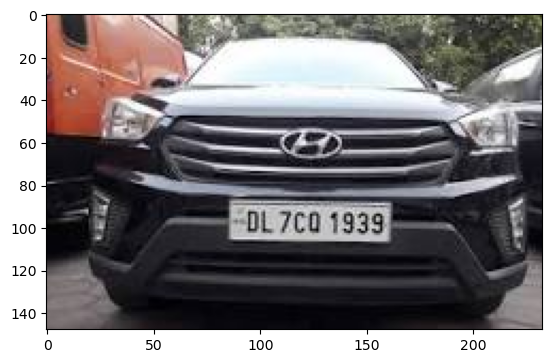

In [4]:
from matplotlib import pyplot as plt
plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))

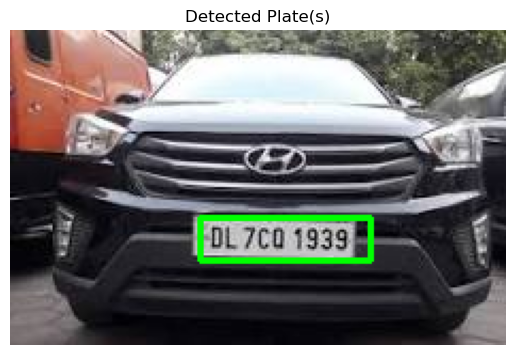

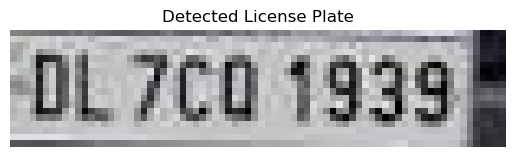

In [5]:
# Step 1: Load the image
image_path = r'C:\Users\DELL\Downloads\number_plateimage2.jpeg'
img_input = cv2.imread(image_path)

if img_input is None:
    raise ValueError(f"❌ Image could not be loaded. Check the path: {image_path}")

# Optional: Resize or preprocess image to improve detection
img_input_gray = cv2.cvtColor(img_input, cv2.COLOR_BGR2GRAY)
img_input_gray = cv2.equalizeHist(img_input_gray)

# Step 2: Load Haar cascade
cascade_path = r'C:\Users\DELL\Downloads\haarcascade_indian_license_plate.xml'
haarcascade = cv2.CascadeClassifier(cascade_path)

if haarcascade.empty():
    raise IOError(f"❌ Haar cascade could not be loaded. Check the path: {cascade_path}")

# Step 3: Detect license plates
plate_contour = haarcascade.detectMultiScale(img_input_gray, scaleFactor=1.1, minNeighbors=3)

# Debug: show detection
debug_img = img_input.copy()
for (x, y, w, h) in plate_contour:
    cv2.rectangle(debug_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(debug_img, cv2.COLOR_BGR2RGB))
plt.title("Detected Plate(s)")
plt.axis("off")
plt.show()

if len(plate_contour) == 0:
    raise ValueError("❌ No license plate found. Try a clearer image or adjust detection parameters.")

# Step 4: Crop the first detected plate
x, y, w, h = plate_contour[0]
a, b = (int(0.01 * img_input.shape[0]), int(0.0125 * img_input.shape[1]))
plate_cropped_img = img_input[y + a:y + h - a, x + b:x + w - b]

if plate_cropped_img is None or plate_cropped_img.size == 0:
    raise ValueError("❌ plate_cropped_img is empty or invalid.")

# Step 5: Show cropped plate
plt.imshow(cv2.cvtColor(plate_cropped_img, cv2.COLOR_BGR2RGB))
plt.title("Detected License Plate")
plt.axis("off")
plt.show()

# Step 6: Preprocess plate for contour detection
plate_resized = cv2.resize(plate_cropped_img, (333, 75))
img_gray = cv2.cvtColor(plate_resized, cv2.COLOR_BGR2GRAY)
_, img_bin = cv2.threshold(img_gray, 200, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Morphological processing
kernel = np.ones((3, 3), np.uint8)
img_erode = cv2.erode(img_bin, kernel, iterations=1)
img_dilate = cv2.dilate(img_erode, kernel, iterations=1)

# Remove borders
img_dilate[0:3, :] = 255
img_dilate[:, 0:3] = 255
img_dilate[72:75, :] = 255
img_dilate[:, 330:333] = 255

# Step 7: Character dimension constraints
LP_WIDTH = img_dilate.shape[0]
LP_HEIGHT = img_dilate.shape[1]
dimensions = [LP_WIDTH / 6, LP_WIDTH / 2, LP_HEIGHT / 10, 2 * LP_HEIGHT / 3]

# Step 8: Find contours for characters
contours, _ = cv2.findContours(img_dilate.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Dimensions unpacking
min_char_height, max_char_height, min_char_width, max_char_width = dimensions

# Sort and filter contours
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:15]
x_contour_list = []
bin_img = []

for contour in contours:
    c_X, c_Y, c_width, c_height = cv2.boundingRect(contour)

    if min_char_width < c_width < max_char_width and min_char_height < c_height < max_char_height:
        x_contour_list.append(c_X)

        char = img_dilate[c_Y:c_Y + c_height, c_X:c_X + c_width]
        char = cv2.resize(char, (20, 40))
        char = cv2.subtract(255, char)

        char_temp = np.zeros((44, 24))
        char_temp[2:42, 2:22] = char

        bin_img.append(char_temp)

# Step 9: Sort character images left-to-right
if len(bin_img) == len(x_contour_list) and len(bin_img) > 0:
    indices = sorted(range(len(x_contour_list)), key=lambda k: x_contour_list[k])
    bin_img_sorted = [bin_img[i] for i in indices]
    bin_img = np.array(bin_img_sorted)
    print(f"✅ Extracted {len(bin_img)} character candidates.")

    # Optional: Display extracted characters
    for idx, char_img in enumerate(bin_img):
        plt.subplot(1, len(bin_img), idx + 1)
        plt.imshow(char_img, cmap='gray')
        plt.axis('off')
    plt.suptitle("Segmented Characters")
    plt.show()


<h3>Image PreProcessing</h3>

<span>
In this process we will:
<ul>

<li>
Convert color function = Convert the image from 3 channel BGR to 1 channel 8-bit format, where range[0,255] || [black,white]
</li>

<li>
Threshold function = The greyscale image is now coverted to binary format where 0 is black and 1 is white. It is done by applying a threshold at 200 between values 0 and 255. 
    <ul>
        <li>if the value pixel is < 200 then the pixel is black</li>
        <li>elif the value of pixel is > 200 then the pixel is white</li>
    </ul>
</li>

<li> Eroding : Here we remove unwanted pixels from the image's edges. It considers the pixel and all neighbours to give a result.
    <ul>
        <li>The text font is black and the bgColor is white.</li>
        <li>Any noise on the edges will be black or 0.</li>
        <li>It considers each pixel one by one.</li>
        <li>What we are addressing - Pixel which should have value 1 but have value 0. (Smoothing edges)</li>
    </ul>
</li>

<li> 
    Dilation : Here we remove any absent pixels from the image. It considers the pixel and only 1 neighbour to give a result.
    <ul>
        <li>It works similar to eroding.</li>
    </ul>
</li>

<li> 
    Make borders white to remove any out of frame pixels.
</li>

<li> 
    Define a list of dimensions that contains 4 values.
    <ul>
        <li>We will use these values to compare with a character’s dimensions.</li>
        <li>That will help us find the right character.</li>
    </ul>
</li>
</ul>
The image is ready for character extraction.
</span>

In [6]:
if plate_cropped_img is not None and plate_cropped_img.size != 0:
    # Resize the cropped plate image
    plate_cropped_img = cv2.resize(plate_cropped_img, (333, 75))

    # Convert to grayscale
    img_gray = cv2.cvtColor(plate_cropped_img, cv2.COLOR_BGR2GRAY)

    # Apply binary thresholding
    _, img_bin = cv2.threshold(img_gray, 200, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Morphological processing
    kernel = np.ones((3, 3), np.uint8)
    img_erode = cv2.erode(img_bin, kernel, iterations=1)
    img_dilate = cv2.dilate(img_erode, kernel, iterations=1)

    # Clean borders
    img_dilate[0:3, :] = 255
    img_dilate[:, 0:3] = 255
    img_dilate[-3:, :] = 255
    img_dilate[:, -3:] = 255

else:
    print("Error: Cropped license plate image is empty. Detection might have failed.")


<h3>What is Contour?</h3>
<span>
    A contour is a curve of a particular color and intensity which joins all continuous points with the same boundary.

<br><br>


In [7]:
# Finding contours in a copy of the pre-processed image
contours, _ = cv2.findContours(img_dilate.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Finding dimensions
lower_width = dimensions[0]
upper_width = dimensions[1]
lower_height = dimensions[2]
upper_height = dimensions[3]

# Sorting the largest contours 15 contours in desc order
contours = sorted(contours, key = cv2.contourArea, reverse=True )[:15]

x_contour_list = []
# List that stores character's bin img
bin_img = []

for contour in contours:
    # Find coordinates of the bounding rectangle around contour
    c_X, c_Y, c_width, c_height = cv2.boundingRect(contour)

    if lower_width < c_width and c_width < upper_width and lower_height < c_height and c_height < upper_height:
        # Storing the x coordinate of the contour for sorting later
        x_contour_list.append(c_X)

        # Making a numpy array of 44 rows and 24 columns
        char_temp = np.zeros((44,24))
        # Extracting the character by using the bounding rectangle coordinates of the contour
        char = img_dilate[c_Y:c_Y+c_height,c_X:c_X+c_width]
        # Resizing the character image
        char = cv2.resize(char,(20,40))
        # Invert Colors
        char = cv2.subtract(255,char)

        # Generating temp character(44,24) with black borders and character
        char_temp[2:42,2:22] = char 
        # black borders
        char_temp[0:2,:]= 0
        char_temp[:,0:2]= 0
        char_temp[42:44,:]= 0
        char_temp[:,22:24]= 0

        # Adding the bin image in list *The characters may be unsorted here
        bin_img.append(char_temp)

# Returning the characters in asc order wrt the x coordinates stored in x_contour_list
indices = sorted(range(len(x_contour_list)), key = lambda k : x_contour_list[k])
# Using sorted indices to sort bin_img list
bin_img_copy = []
for index in indices:
    bin_img_copy.append(bin_img[index])
bin_img = np.array(bin_img_copy)

##  Model Training
Building the Convolutional Neural Network (CNN) model to classify the individual characters. The model consists of convolutional layers, pooling layers, dropout layers, and fully connected layers.

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from tensorflow.keras.optimizers import Adam

In [9]:
model = Sequential()
model.add(Conv2D(32, (24,24), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

optimizer = Adam(learning_rate=0.00001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

c:\Users\dell\Desktop\LicensePlateNumber-main\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras

# Image Data Augmentation
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)

# Paths for training and validation data
data_train_path = 'C:\\Users\\dell\\Desktop\\LicensePlateNumber-main\\data\\train'
data_val_path = 'C:\\Users\\dell\\Desktop\\LicensePlateNumber-main\\data\\val'

# Batch size
batch_size = 1

# Training Data Generator
train_generator = train_datagen.flow_from_directory(data_train_path,  
                                                    target_size=(28,28),  
                                                    batch_size=batch_size, 
                                                    class_mode='categorical')

# Validation Data Generator
validation_generator = train_datagen.flow_from_directory(data_val_path, 
                                                         target_size=(28,28), 
                                                         batch_size=batch_size, 
                                                         class_mode='categorical')

# Define Early Stopping with Validation Accuracy (commented out)
# early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, verbose=1)

# Define the Accuracy Callback
class AccuracyCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= 0.99:
            print(f"\nReached 99% accuracy, stopping training at epoch {epoch+1}!")
            self.model.stop_training = True

# Create an instance of the callback
callback = AccuracyCallback()

# Train the Model
model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples // batch_size,
      validation_data=validation_generator, 
      validation_steps=validation_generator.samples // batch_size,
      epochs=100,  # Running for 50 epochs
      callbacks=[callback])  # Using only the AccuracyCallback


Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.
Epoch 1/100


c:\Users\dell\Desktop\LicensePlateNumber-main\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


864/864 ━━━━━━━━━━━━━━━━━━━━ 32s 33ms/step - accuracy: 0.0513 - loss: 3.5557 - val_accuracy: 0.1574 - val_loss: 3.4263
Epoch 2/100
864/864 ━━━━━━━━━━━━━━━━━━━━ 27s 31ms/step - accuracy: 0.1395 - loss: 3.3246 - val_accuracy: 0.3241 - val_loss: 2.9144
Epoch 3/100
864/864 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - accuracy: 0.2672 - loss: 2.8516 - val_accuracy: 0.5509 - val_loss: 2.3773
Epoch 4/100
864/864 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - accuracy: 0.4087 - loss: 2.2362 - val_accuracy: 0.5833 - val_loss: 1.9519
Epoch 5/100
864/864 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.4807 - loss: 1.9033 - val_accuracy: 0.6574 - val_loss: 1.6030
Epoch 6/100
864/864 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5592 - loss: 1.6261 - val_accuracy: 0.6991 - val_loss: 1.4076
Epoch 7/100
864/864 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.6134 - loss: 1.3678 - val_accuracy: 0.7639 - val_loss: 1.1277
Epoch 8/100
864/864 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.6899 - loss: 1.1604 - val_

In [12]:
model.save('trained_model.h5')

In [27]:
from keras.models import load_model
model = load_model('trained_model.h5')

def fix_dimension(img): 
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img
  
dic = {}
characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
for i,c in enumerate(characters):
    dic[i] = c

output = []
plate_number = ''
for i,ch in enumerate(bin_img): #iterating over the characters
    img_ = cv2.resize(ch, (28,28))
    img = fix_dimension(img_)
    img = img.reshape(1,28,28,3) #preparing image for the model
    y_ = model.predict(img)[0] #predicting the class
    # print(y_)
    index = np.where(y_ == 1)[0]
    int_index = int(index[0])
    # print(int_index)
    plate_number += dic[int_index]
print(plate_number)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
NH01AY8866


## Evaluation Metrics
- Model Evaluation : After training, we evaluate the model using the validation data to obtain the final loss and accuracy metrics.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model on validation data
loss, accuracy = model.evaluate(validation_generator, verbose=0)

# Display the final evaluation metrics
print(f"\nFinal Evaluation Metrics:")
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy * 100:.2f}%")

# If you want to print more detailed metrics like Precision, Recall, and F1-Score
y_true = validation_generator.classes
y_pred = []

# Predict on the validation set
for i in range(len(validation_generator)):
    img_batch, label_batch = validation_generator[i]
    pred_batch = model.predict(img_batch, verbose=0)  # Suppress the step logs
    y_pred.extend(np.argmax(pred_batch, axis=1))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Classification Report
report = classification_report(y_true, y_pred, target_names=list(dic.values()))
print("\nClassification Report:")
print(report)



Final Evaluation Metrics:
Loss: 0.0586
Accuracy: 97.69%

Confusion Matrix:
[[1 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [1 0 0 ... 1 0 0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.17      0.18         6
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         6
           5       0.17      0.17      0.17         6
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         6
           A       0.00      0.00      0.00         6
           B       0.00      0.00      0.00         6
           C       0.17      0.17      0.17         6
           D       0.00